In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import yfinance as yf

In [116]:
assets = ['MSFT']

In [117]:
stockStartDate = '2011-01-01'
stockStartDate

'2011-01-01'

In [118]:
today = datetime.today().strftime('%Y-%m-%d') #format this variable to time
today

'2022-10-18'

In [119]:
# Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

#You may get symbol may be delisted... please retry again
# Store the adjusted close price of the stock into the df
for stock in assets:
    df[stock] = yf.download(stock, data_source='yahoo', start = stockStartDate, end = today)['Adj Close']

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

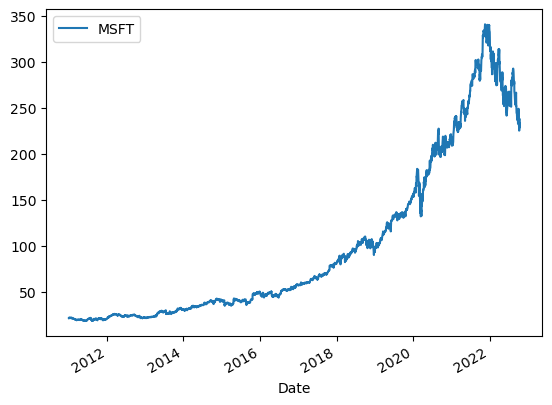

In [120]:
df.plot()

In [121]:
# Scale/Normalize the data to make all values between 0 and 1
dataset = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00966426],
       [0.00993179],
       [0.0097129 ],
       ...,
       [0.66889094],
       [0.65125541],
       [0.67910585]])

In [122]:
# Creating training data size : until just before August 1
training_data_len = 2913
train_data = scaled_data[0:2913, : ]
 
# Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(30,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-30:i,0])
    y_train_data.append(train_data[i,0])

In [123]:
#  Converting the training x and y values to numpy arrays
x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)

# Reshaping training s and y data to make the calculations easier
x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

In [124]:
unit1 = [30,50,70]
unit2 = [30,50,70]
dense1 = [10,25]
dense2 = [1,5]

In [125]:
#grid search
result = []
for i in unit1:
    for j in unit2:
        for k in dense1:
            for l in dense2:
                model = Sequential()
                #grid search for unit1, unit2
                model.add(LSTM(units=i, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
                model.add(LSTM(units=j, return_sequences=False))
                model.add(Dense(units=k))
                model.add(Dense(units=l))
                model.compile(optimizer='adam', loss='mean_squared_error')
                model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)
                test_data = scaled_data[training_data_len - 30: , : ]
                x_test = []
                y_test =  dataset[training_data_len : , : ]
                for i in range(30,len(test_data)):
                    x_test.append(test_data[i-30:i,0])
                x_test = np.array(x_test)
                x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
                predictions = model.predict(x_test)
                predictions = scaler.inverse_transform(predictions)
                rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
                result.append([i,j,k,l,rmse])

2/2 [==============================] - 1s 11ms/step


In [141]:
result.sort(key = lambda x: x[4])
best_parameter = result[1]
best_parameter

[84, 50, 10, 1, 8.48198256732665]

In [127]:
#using the best params, we train the model again, with more epochs
model = Sequential()
unit1, unit2, dense1, dense2 = best_parameter[0], best_parameter[1], best_parameter[2], best_parameter[3]
#grid search for unit1, unit2
model.add(LSTM(units=unit1, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=unit2, return_sequences=False))
model.add(Dense(units=dense1))
model.add(Dense(units=dense2))
model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=10)

Epoch 1/10
2883/2883 [==============================] - 42s 13ms/step - loss: 0.0012
Epoch 2/10
2883/2883 [==============================] - 43s 15ms/step - loss: 5.2497e-04
Epoch 3/10
2883/2883 [==============================] - 43s 15ms/step - loss: 3.1070e-04
Epoch 4/10
2883/2883 [==============================] - 44s 15ms/step - loss: 2.5407e-04
Epoch 5/10
2883/2883 [==============================] - 45s 15ms/step - loss: 2.3110e-04
Epoch 6/10
2883/2883 [==============================] - 43s 15ms/step - loss: 2.0464e-04
Epoch 7/10
2883/2883 [==============================] - 43s 15ms/step - loss: 1.7879e-04
Epoch 8/10
2883/2883 [==============================] - 44s 15ms/step - loss: 1.8237e-04
Epoch 9/10
2883/2883 [==============================] - 44s 15ms/step - loss: 1.7619e-04
Epoch 10/10
2883/2883 [==============================] - 43s 15ms/step - loss: 1.6936e-04


In [129]:
test_data = scaled_data[training_data_len - 30: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(30,len(test_data)):
    x_test.append(test_data[i-30:i,0])

In [130]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 12ms/step


In [131]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

6.287610740531934


In [132]:
train = df[:training_data_len]
valid = df[training_data_len:]

In [133]:
valid = df[training_data_len:len(df)]

In [134]:
predictions

array([[284.30115],
       [281.3418 ],
       [276.1023 ],
       [280.68045],
       [284.70422],
       [285.0253 ],
       [282.28857],
       [282.73236],
       [288.98407],
       [289.67358],
       [292.57874],
       [294.58798],
       [294.12286],
       [292.9105 ],
       [291.66467],
       [288.3684 ],
       [280.8779 ],
       [277.81976],
       [277.84555],
       [281.16135],
       [273.92282],
       [268.09256],
       [265.33997],
       [264.4136 ],
       [263.88943],
       [260.41653],
       [256.81247],
       [259.83487],
       [262.13263],
       [267.08328],
       [270.06573],
       [258.3679 ],
       [253.0834 ],
       [248.00026],
       [246.95065],
       [247.68504],
       [246.67564],
       [243.24457],
       [243.4892 ],
       [241.82721],
       [240.68527],
       [239.66998],
       [243.14523],
       [241.9468 ],
       [236.98561],
       [241.23509],
       [250.58524],
       [253.789  ],
       [250.95055],
       [238.91628],


In [135]:
predictions = predictions[:len(predictions)]

In [136]:
valid

,MSFT
Date,
2022-08-01 00:00:00-04:00,277.421143
2022-08-02 00:00:00-04:00,274.237915
2022-08-03 00:00:00-04:00,281.871704
2022-08-04 00:00:00-04:00,283.049194
2022-08-05 00:00:00-04:00,282.310760
2022-08-08 00:00:00-04:00,279.726257
2022-08-09 00:00:00-04:00,281.702057
2022-08-10 00:00:00-04:00,288.547516
2022-08-11 00:00:00-04:00,286.412048


In [137]:
valid['Predictions'] = predictions

C:\Users\Kern Chern\AppData\Local\Temp\ipykernel_13960\568117345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [138]:
valid

,MSFT,Predictions
Date,,
2022-08-01 00:00:00-04:00,277.421143,284.301147
2022-08-02 00:00:00-04:00,274.237915,281.341797
2022-08-03 00:00:00-04:00,281.871704,276.102295
2022-08-04 00:00:00-04:00,283.049194,280.680450
2022-08-05 00:00:00-04:00,282.310760,284.704224
2022-08-08 00:00:00-04:00,279.726257,285.025299
2022-08-09 00:00:00-04:00,281.702057,282.288574
2022-08-10 00:00:00-04:00,288.547516,282.732361
2022-08-11 00:00:00-04:00,286.412048,288.984070


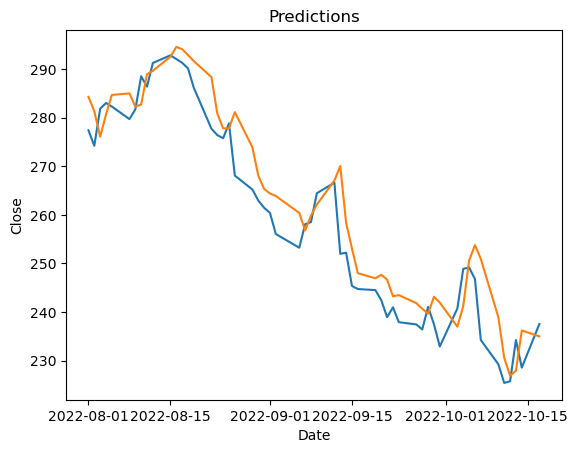

In [139]:
plt.title('Predictions')
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(valid)

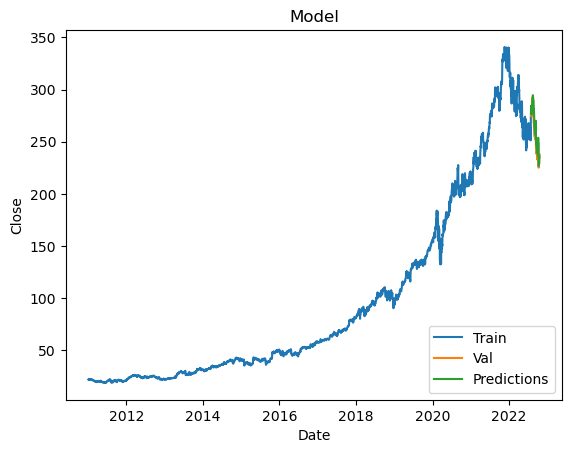

In [140]:
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(df)
plt.plot(valid[['MSFT', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()